## SSZ-QL and GMP
This is a PoC pursues three technical objectives:
- reinforce the rationale for the Fellowship project
- quantify the efficiency improvements unlocked by the proposed approach
- validate merkle proofs and multiproofs in a realistic setting

Our starting point is `class BeaconState`, the "God's object" that gives us a versatile surface for exercising multiple use-case scenarios.

In [3]:
# Added this snippet to prevent uploading a beacon state to github: 
# Download the finalized BeaconState as raw SSZ
# (≈︎ `curl -o state.ssz -H 'Accept: application/octet-stream' \
#    https://beaconstate.ethstaker.cc/eth/v2/debug/beacon/states/finalized`)

import requests

RPC = "https://beaconstate.ethstaker.cc/eth/v2/debug/beacon/states/finalized"
HEADERS = {"Accept": "application/octet-stream"}
OUTFILE = "state.ssz"

with requests.get(RPC, headers=HEADERS, stream=True, timeout=30) as resp:
    resp.raise_for_status()                     
    with open(OUTFILE, "wb") as fp:
        for chunk in resp.iter_content(8192):   
            if chunk:                           
                fp.write(chunk)

In [8]:
# Here we are using the same "BeaconState" from a given SSZ file for the sake of simplicity. We could retrieve different ones on-demmand, but it would slow down the process.
import os
import eth2spec.electra.mainnet as spec

beacon_state_path = "state.ssz"
beacon_state_size = os.stat(beacon_state_path).st_size
print(f"Beacon state file size: {beacon_state_size} bytes !!!")

state: spec.BeaconState
with open(beacon_state_path, "rb") as f:
    state = spec.BeaconState.deserialize(f, beacon_state_size)


print(f"Successfully loaded the beacon state for slot {state.slot}")

Beacon state file size: 284409843 bytes !!!
Successfully loaded the beacon state for slot 12131008


**Note:** The following are different ways to represent the Path, for consideration during spec finalization.  
Source: [Ethereum consensus-specs issue #2179](https://github.com/ethereum/consensus-specs/issues/2179#issuecomment-759305714)

- An `anchor_type`, `Sequence[Union[int, SSZVariableName]]` tuple (like now, but abstracted away)  
- An `anchor_type`, `GeneralizedIndex` tuple (what Go/Rust implementations may prefer)  
- A literal URI string (more readable, less performant)  
- Some kind of pointer structure  
- Something precomputed

SSZ-QL MUST provide enough flexibility to ask for any arbitrary field or data from any object within the Consensus Layer.

Below are several demonstration queries that highlight its capabilities:

In [ ]:
import json

# Case 1: verify domain with the genesis_validators_root and the current fork version
# `POST` https://RPC/eth/v1/beacon/states/finalized/query
# {
#   "query": [
#     {
#       "path": ".genesis_validators_root",
#       "include_proof": false
#     },
#     {
#       "path": ".fork.current_version",
#       "include_proof": false
#     }
#   ]
# }

# This toy example helps us identify the structure of the SSZ-QL response, there could be multiple ways to represent the data: 
# - inferring to which path the values correspond to by their order
# - explicitly adding the `path` field to each data retrieved.

sszql_response = json.dumps(
    {
        "version": "electra",
        "execution_optimistic": True,
        "finalized": True,
        "data": [
            {
                "value": "0x"+state.genesis_validators_root.hex(), 
            },
            {
                "value": "0x"+state.fork.current_version.hex(),
            }
        ]
    },
    indent=2
)

print("SSZ-QL response (ordered data reply): \n",sszql_response)

sszql_response = json.dumps(
    {
        "version": "electra",
        "execution_optimistic": True,
        "finalized": True,
        "data": [
            {
                "path": ".fork.current_version",
                "value": "0x"+state.fork.current_version.hex(),
            },
            {
                "path": ".genesis_validators_root",
                "value": "0x"+state.genesis_validators_root.hex(), 
            }
        ]
    },
    indent=2
)

print("SSZ-QL response (explicit): \n",sszql_response)

# I like it better when the data is explicit and self-contained, so the query is not needed to understand the response.

SSZ-QL response (ordered data reply): 
 {
  "version": "electra",
  "execution_optimistic": true,
  "finalized": true,
  "data": [
    {
      "value": "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95"
    },
    {
      "value": "0x05000000"
    }
  ]
}
SSZ-QL response (explicit): 
 {
  "version": "electra",
  "execution_optimistic": true,
  "finalized": true,
  "data": [
    {
      "path": ".fork.current_version",
      "value": "0x05000000"
    },
    {
      "path": ".genesis_validators_root",
      "value": "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95"
    }
  ]
}


The previous SSZ-QL query shows only a minimal use case and offers little practical value because the returned fields are not cryptographically proven.

The core objective of SSZ-QL & GMP is to fetch any subset of fields efficiently. Bundling Merkle proofs with each response lets a client verify the data’s integrity without downloading the entire beacon state.

In [11]:
# Helper functions to compute Merkle proofs https://github.com/ethereum/consensus-specs/issues/2179#issuecomment-1399477411
from remerkleable.tree import merkle_hash
from remerkleable.core import Path

def compute_merkle_proof_for_state(state, gindex) -> tuple[int, list[hex]]:
    merkle_tree = state.get_backing()
    node = merkle_tree

    # print("Beacon state root from beacon state:", merkle_tree.merkle_root().hex())

    # 1 less because bitlength returns 1 more than we need to shift, and 1 less because we don't care about the root
    check_bit = 1 << (gindex.bit_length()-2)
    # print("check bit:", bin(check_bit))
    witness = []
    while check_bit > 0:
        if check_bit & gindex != 0:  # follow bit path of target gindex, and get sibling nodes as witness
            witness.append(node.get_left().merkle_root())
            node = node.get_right()
        else:
            witness.append(node.get_right().merkle_root())
            node = node.get_left()
        check_bit >>= 1

    # print("Requested field:", node.merkle_root().hex())
    # print("witness:")

    # for i, sib in enumerate(reversed(witness)):
        # print(f"{i:3}: {sib.hex()}")

    # now let's see if we can verify the proof
    x = node.merkle_root()
    for i, sib in enumerate(reversed(witness)):
        if (1 << i) & gindex != 0:
            x = merkle_hash(sib, x)
        else:
            x = merkle_hash(x, sib)

    # print("Reconstructed state root from proof and value, to verify against real state:", x.hex())

    return [sib.hex() for sib in reversed(witness)]

In [19]:
# Replace previous code snippet with this `compute_merkle_proof` function
from eth2spec.electra.mainnet import get_generalized_index, compute_merkle_proof, is_valid_merkle_branch,floorlog2, BeaconState

proofs = compute_merkle_proof(state, get_generalized_index(BeaconState,'genesis_validators_root'))
state_root = state.hash_tree_root()

assert is_valid_merkle_branch(
      leaf=state.genesis_validators_root,
      branch=proofs,
      depth = floorlog2(get_generalized_index(BeaconState,'genesis_validators_root')),
      index=get_generalized_index(BeaconState,'genesis_validators_root'),
      root=state_root,
)

In [16]:
# Case 2: verify domain with the genesis_validators_root and the current fork version
# `POST` https://RPC/eth/v1/beacon/states/finalized/query
# {
#   "query": [
#     {
#       "path": ".genesis_validators_root",
#       "include_proof": true
#     },
#     {
#       "path": ".fork.current_version",
#       "include_proof": true
#     }
#   ]
# }
# This toy example helps us identify the structure of the SSZ-QL response, both fields are to be proven. Do they want single merkle proofs or just a multi proof?
# We need to improve the query

genesis_validators_root_path = Path(spec.BeaconState) / 'genesis_validators_root'
genesis_validators_root_gindex = genesis_validators_root_path.gindex()

fork_version_path = Path(spec.BeaconState) / 'fork' / 'current_version'
fork_version_gindex = fork_version_path.gindex()

print(f"Merkle path for genesis_validators_root: {genesis_validators_root_path}")
print(f"\nTarget gindex: {genesis_validators_root_gindex}")

print(f"Merkle path for genesis_validators_root: {fork_version_path}")
print(f"Target gindex: {fork_version_gindex}")

print(f"Fork current version: {state.fork.current_version.hex()}")

state_root = state.hash_tree_root()
print(f"Beacon state hash tree root: {state_root.hex()}")

genesis_validators_root_witness=compute_merkle_proof_for_state(state, genesis_validators_root_gindex)
fork_version_witness=compute_merkle_proof_for_state(state, fork_version_gindex)

sszql_response = json.dumps(
    {
        "version": "electra",
        "execution_optimistic": True,
        "finalized": True,
        "data": [
            {
                "path": ".genesis_validators_root",
                "value": "0x"+state.genesis_validators_root.hex(), # in a subsequent iteration we can do this dynamically, grabbing the value from the sszql_query variable.
                "proofs": [
                    {
                        "gindex": genesis_validators_root_gindex,
                        "witness": [sib for sib in genesis_validators_root_witness],
                    }
                ],
                "state_root": "0x"+state_root.hex()
            },
            {
                "path": ".fork.current_version",
                "value": "0x"+state.fork.current_version.hex(),
                "proofs": [
                    {
                        "gindex": fork_version_gindex,
                        "witness": [sib for sib in fork_version_witness],
                    }
                ],
                "state_root": "0x"+state_root.hex() # it is probably redundant to include a state_root per value. Are we allowing different state_roots per query? In this case we would need to include it in the query.
            }
        ]
    },
    indent=2
)


print("\n\nSSZ-QL response: \n",sszql_response)

Merkle path for genesis_validators_root: <remerkleable.core.Path object at 0x3a34006a0>

Target gindex: 65
Merkle path for genesis_validators_root: <remerkleable.core.Path object at 0x3a34039d0>
Target gindex: 269
Fork current version: 05000000
Beacon state hash tree root: 050de1a06c7e559936381bb10c358a18a999d59099f1389d73e89b069a8fa7bc


SSZ-QL response: 
 {
  "version": "electra",
  "execution_optimistic": true,
  "finalized": true,
  "data": [
    {
      "path": ".genesis_validators_root",
      "value": "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95",
      "proofs": [
        {
          "gindex": 65,
          "witness": [
            "5730c65f00000000000000000000000000000000000000000000000000000000",
            "b8aaa4806be5e56955b0ee7ef84b8f074c32fadba5e66ee7e1915b3513e8d924",
            "bfa0e13654c5db4d59555674f42ff885a6ea987b8aa3b8f07ae56028d767f598",
            "556f14773ab8ef468c22af47f54f61d8e56b856bb835fe9ff40f2eb1ef1cbe5a",
            "cdd53f3e

As expected, most single-leaf proofs share identical hash nodes because the leaves lie on overlapping Merkle paths. A compact Merkle multiproof eliminates this redundancy by proving all target leaves in one shot, shipping only the minimal witness set.

### Multiproofs
The multiproof generation is based on [Consensus Layer spec](https://github.com/ethereum/consensus-specs/blob/dev/ssz/merkle-proofs.md).
We need to only model the input and output.

In [35]:
from eth2spec.electra.mainnet import GeneralizedIndex, Sequence, Set, Bytes32, Root
from eth2spec.utils.hash_function import hash

def get_power_of_two_ceil(x: int) -> int:
    if x <= 1:
        return 1
    elif x == 2:
        return 2
    else:
        return 2 * get_power_of_two_ceil((x + 1) // 2)


def get_power_of_two_floor(x: int) -> int:
    if x <= 1:
        return 1
    if x == 2:
        return x
    else:
        return 2 * get_power_of_two_floor(x // 2)
    
def concat_generalized_indices(*indices: GeneralizedIndex) -> GeneralizedIndex:
    """
    Given generalized indices i1 for A -> B, i2 for B -> C .... i_n for Y -> Z, returns
    the generalized index for A -> Z.
    """
    o = GeneralizedIndex(1)
    for i in indices:
        o = GeneralizedIndex(o * get_power_of_two_floor(i) + (i - get_power_of_two_floor(i)))
    return o

def get_generalized_index_length(index: GeneralizedIndex) -> int:
    """
    Return the length of a path represented by a generalized index.
    """
    return int(log2(index))

def get_generalized_index_bit(index: GeneralizedIndex, position: int) -> bool:
    """
    Return the given bit of a generalized index.
    """
    return (index & (1 << position)) > 0

def generalized_index_sibling(index: GeneralizedIndex) -> GeneralizedIndex:
    return GeneralizedIndex(index ^ 1)

def generalized_index_child(index: GeneralizedIndex, right_side: bool) -> GeneralizedIndex:
    return GeneralizedIndex(index * 2 + right_side)

def generalized_index_parent(index: GeneralizedIndex) -> GeneralizedIndex:
    return GeneralizedIndex(index // 2)

def get_branch_indices(tree_index: GeneralizedIndex) -> Sequence[GeneralizedIndex]:
    """
    Get the generalized indices of the sister chunks along the path from the chunk with the
    given tree index to the root.
    """
    o = [generalized_index_sibling(tree_index)]
    while o[-1] > 1:
        o.append(generalized_index_sibling(generalized_index_parent(o[-1])))
    return o[:-1]

def get_path_indices(tree_index: GeneralizedIndex) -> Sequence[GeneralizedIndex]:
    """
    Get the generalized indices of the chunks along the path from the chunk with the
    given tree index to the root.
    """
    o = [tree_index]
    while o[-1] > 1:
        o.append(generalized_index_parent(o[-1]))
    return o[:-1]

def get_helper_indices(indices: Sequence[GeneralizedIndex]) -> Sequence[GeneralizedIndex]:
    """
    Get the generalized indices of all "extra" chunks in the tree needed to prove the chunks with the given
    generalized indices. Note that the decreasing order is chosen deliberately to ensure equivalence to the
    order of hashes in a regular single-item Merkle proof in the single-item case.
    """
    all_helper_indices: Set[GeneralizedIndex] = set()
    all_path_indices: Set[GeneralizedIndex] = set()
    for index in indices:
        all_helper_indices = all_helper_indices.union(set(get_branch_indices(index)))
        all_path_indices = all_path_indices.union(set(get_path_indices(index)))

    return sorted(all_helper_indices.difference(all_path_indices), reverse=True)

def calculate_merkle_root(leaf: Bytes32, proof: Sequence[Bytes32], index: GeneralizedIndex) -> Root:
    assert len(proof) == get_generalized_index_length(index)
    for i, h in enumerate(proof):
        if get_generalized_index_bit(index, i):
            leaf = hash(h + leaf)
        else:
            leaf = hash(leaf + h)
    return leaf


def verify_merkle_proof(
    leaf: Bytes32, proof: Sequence[Bytes32], index: GeneralizedIndex, root: Root
) -> bool:
    return calculate_merkle_root(leaf, proof, index) == root


def calculate_multi_merkle_root(
    leaves: Sequence[Bytes32], proof: Sequence[Bytes32], indices: Sequence[GeneralizedIndex]
) -> Root:
    assert len(leaves) == len(indices)
    helper_indices = get_helper_indices(indices)
    # print("Helper indices:", helper_indices)
    assert len(proof) == len(helper_indices)
    objects = {
        **{index: node for index, node in zip(indices, leaves)},
        **{index: node for index, node in zip(helper_indices, proof)},
    }
    # print("Initial objects:", objects  )
    keys = sorted(objects.keys(), reverse=True)
    pos = 0
    while pos < len(keys):
        k = keys[pos]
        if k in objects and k ^ 1 in objects and k // 2 not in objects:
            objects[GeneralizedIndex(k // 2)] = hash(
                objects[GeneralizedIndex((k | 1) ^ 1)] + objects[GeneralizedIndex(k | 1)]
            )
            keys.append(GeneralizedIndex(k // 2))
        pos += 1
    return objects[GeneralizedIndex(1)]

leaves = [
    state.genesis_validators_root,                      # already Bytes32
    state.fork.current_version.hash_tree_root(),        # needs to convert from Version to Bytes32
]

gvr_branch  = [Bytes32.fromhex(x) for x in compute_merkle_proof_for_state(
                   state, genesis_validators_root_gindex)]
fv_branch   = [Bytes32.fromhex(x) for x in compute_merkle_proof_for_state(
                   state, fork_version_gindex)]

indices = [
    GeneralizedIndex(genesis_validators_root_gindex),
    GeneralizedIndex(fork_version_gindex),
]
helper_indices = get_helper_indices(indices)

# Build an {gindex: node} map with everything we have
objects: dict[GeneralizedIndex, Bytes32] = {
    indices[0]: leaves[0],
    indices[1]: leaves[1],
    **dict(zip(get_branch_indices(indices[0]), gvr_branch)),
    **dict(zip(get_branch_indices(indices[1]), fv_branch)),
}


# Proof list must follow helper-index order returned by get_helper_indices
proof = [objects[i] for i in helper_indices]

print("**********proof:", proof)

# --- final multi-proof verification --------------------------------------
root = calculate_multi_merkle_root(
    leaves=leaves,
    proof=proof,
    indices=indices,
)

assert root == state.hash_tree_root()
print("Multi-proof OK; reconstructed root =", root.hex())

**********proof: [0x0400000000000000000000000000000000000000000000000000000000000000, 0x8e38229b2010e3cde27597c6e4852c4e6cdca82e03574383993cd60250e9ed3a, 0xc01ab90000000000000000000000000000000000000000000000000000000000, 0x5730c65f00000000000000000000000000000000000000000000000000000000, 0xbfa0e13654c5db4d59555674f42ff885a6ea987b8aa3b8f07ae56028d767f598, 0x556f14773ab8ef468c22af47f54f61d8e56b856bb835fe9ff40f2eb1ef1cbe5a, 0xcdd53f3e1245afec352e11f7ced271897efbf59fe8bce1a3f4f2b69e256758b6, 0x415400b4172322cf986ab4a08a96ed9e7c4b754f6588b4b0d9c0cf842704a4e4]
Multi-proof OK; reconstructed root = 050de1a06c7e559936381bb10c358a18a999d59099f1389d73e89b069a8fa7bc


In [ ]:
# Case 3: verify domain with the genesis_validators_root and the current forkk version. Using Merkle Multiproof
# `POST` https://RPC/eth/v1/beacon/states/finalized/query
# {
#   "query": [
#     {
#       "path": ".genesis_validators_root",
#       "include_proof": true
#     },
#     {
#       "path": ".fork.current_version",
#       "include_proof": true
#     }
#   ], 
#   "proof_type": "merkle_multiproof" # --- this is the new field we are adding to the query ---
# }

# Compute Merkle Multiproof for the genesis_validators_root and current fork version
leaves = [
    state.genesis_validators_root,                      # already Bytes32
    state.fork.current_version.hash_tree_root(),        # needs to convert from Version to Bytes32
]

# print("Leaves:", [x.hex() for x in leaves])

gvr_branch  = [Bytes32.fromhex(x) for x in compute_merkle_proof_for_state(
                   state, genesis_validators_root_gindex)]
fv_branch   = [Bytes32.fromhex(x) for x in compute_merkle_proof_for_state(
                   state, fork_version_gindex)]

# print("GVR branch:", [x.hex() for x in gvr_branch])
# print("FV branch:", [x.hex() for x in fv_branch])

indices = [
    GeneralizedIndex(genesis_validators_root_gindex),
    GeneralizedIndex(fork_version_gindex),
]

# print("Indices:", [i for i in indices])

helper_indices = get_helper_indices(indices)

# print("Helper indices:", helper_indices)

# Build an {gindex: node} map with everything we have
objects: dict[GeneralizedIndex, Bytes32] = {
    indices[0]: leaves[0],
    indices[1]: leaves[1],
    **dict(zip(get_branch_indices(indices[0]), gvr_branch)),
    **dict(zip(get_branch_indices(indices[1]), fv_branch)),
}


# Proof list must follow helper-index order returned by get_helper_indices
proof = [objects[i] for i in helper_indices]

# print("**********proof:", proof)

# --- final multi-proof verification --------------------------------------
root = calculate_multi_merkle_root(
    leaves=leaves,
    proof=proof,
    indices=indices,
)

assert root == state.hash_tree_root()
# print("Multi-proof OK; reconstructed root =", root.hex())

sszql_response = json.dumps(
    {
        "version": "electra",
        "execution_optimistic": True,
        "finalized": True,
        "data": [
            {
                "proofs": [
                    {
                        "leaves": ['0x'+x.hex() for x in leaves], 
                        "hashes": [[int(idx), "0x" + node.hex()] for idx, node in objects.items()],
                    }
                ],
                "state_root": "0x"+state_root.hex()
            }
        ]
    },
    indent=2
)


print("\n\nSSZ-QL response: \n",sszql_response)



SSZ-QL response: 
 {
  "version": "electra",
  "execution_optimistic": true,
  "finalized": true,
  "data": [
    {
      "proofs": [
        {
          "leaves": [
            "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95",
            "0x0500000000000000000000000000000000000000000000000000000000000000"
          ],
          "hashes": [
            [
              65,
              "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95"
            ],
            [
              269,
              "0x0500000000000000000000000000000000000000000000000000000000000000"
            ],
            [
              64,
              "0x5730c65f00000000000000000000000000000000000000000000000000000000"
            ],
            [
              33,
              "0xb8aaa4806be5e56955b0ee7ef84b8f074c32fadba5e66ee7e1915b3513e8d924"
            ],
            [
              17,
              "0xbfa0e13654c5db4d59555674f42ff885a6ea987b8aa3b8f07ae56028d767f598

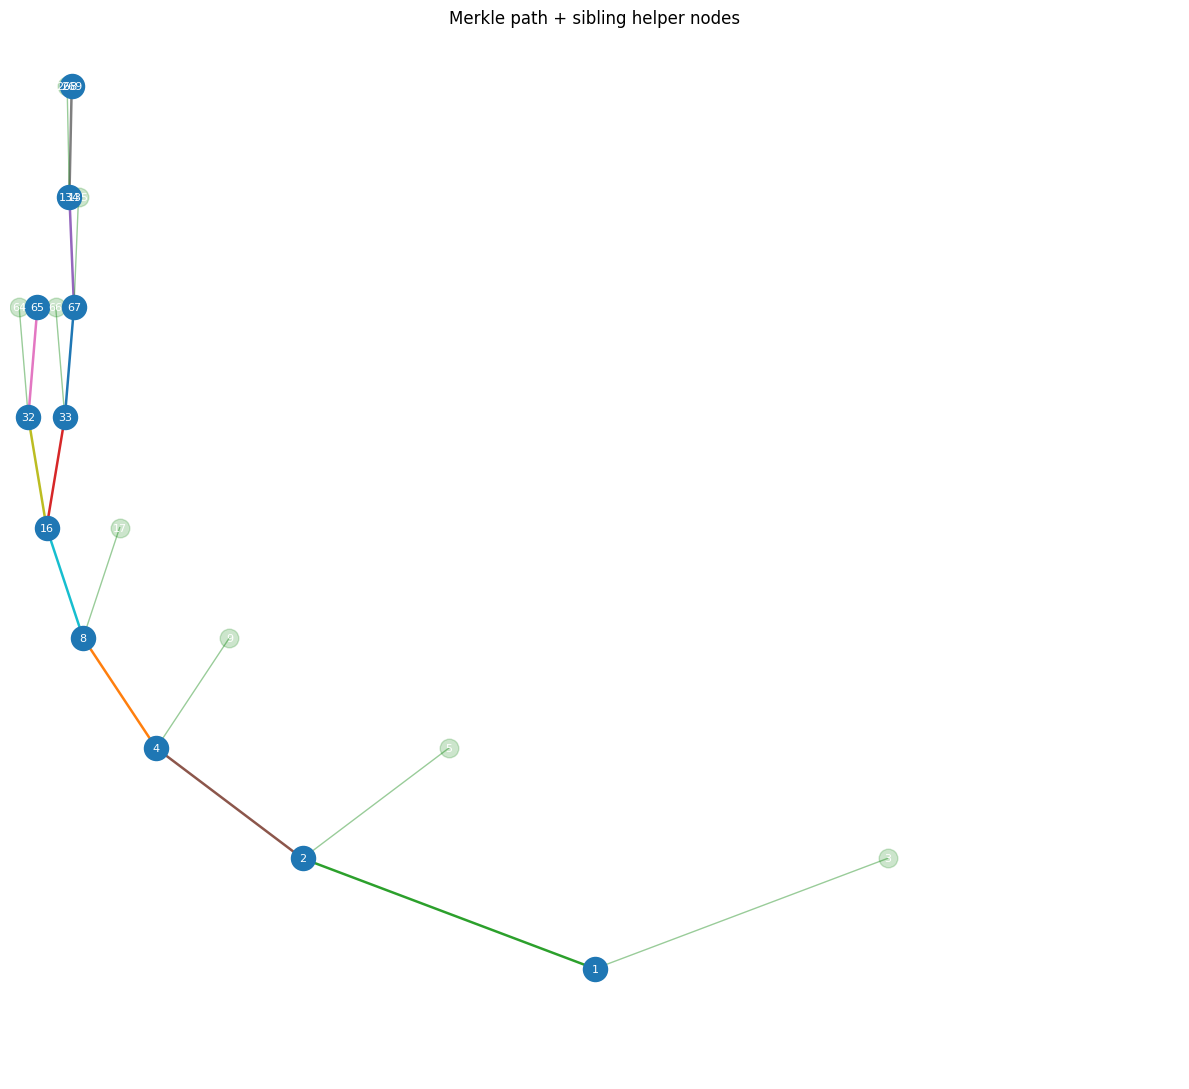

In [ ]:
import matplotlib.pyplot as plt

def plot_merkle_paths(gindexes):
    """
    Draw only the nodes required to verify the given leaves:
      • every node on each leaf-to-root path (inclusive), and
      • the sibling (“helper”) nodes needed for proof verification.

    Path nodes are drawn in the foreground; helper-only nodes/edges appear
    semi-transparent.

    Parameters
    ----------
    gindexes : Sequence[int]
        Generalised indices of the leaves to prove.
    """
    if not gindexes:
        raise ValueError("gindexes must contain at least one index")

    # ── helpers ─────────────────────────────────────────────────────────────
    def depth(idx: int) -> int:               # root depth == 0
        return idx.bit_length() - 1

    max_depth = max(depth(g) for g in gindexes)

    # ── path nodes (leaf→root) ──────────────────────────────────────────────
    path_nodes = set()
    for g in gindexes:
        cur = g
        while True:
            path_nodes.add(cur)
            if cur == 1:
                break
            cur //= 2

    # ── helper (sibling) nodes ──────────────────────────────────────────────
    helper_indices = get_helper_indices([GeneralizedIndex(g) for g in gindexes])
    helper_nodes = set(int(h) for h in helper_indices)

    nodes_to_plot = path_nodes | helper_nodes
    edges_to_plot = {
        (n, n // 2) for n in nodes_to_plot
        if n != 1 and (n // 2) in nodes_to_plot
    }

    # ── 2-D layout ──────────────────────────────────────────────────────────
    coords = {}
    for n in nodes_to_plot:
        d = depth(n)
        slot_w = 2 ** (max_depth - d)
        x = (n & ((1 << d) - 1)) * slot_w + slot_w / 2
        y = max_depth - d
        coords[n] = (x, y)

    # ── plot ────────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(12, 1.1 * (max_depth + 2)))

    # edges: helpers (gray) then path
    for child, parent in edges_to_plot:
        x1, y1 = coords[child]
        x2, y2 = coords[parent]
        if child in path_nodes and parent in path_nodes:
            ax.plot([x1, x2], [y1, y2], linewidth=1.8)
        else:
            ax.plot([x1, x2], [y1, y2], color="green", alpha=0.4, linewidth=1)

    # nodes: helpers then path
    helper_only = [n for n in helper_nodes if n not in path_nodes]
    if helper_only:
        xs, ys = zip(*(coords[n] for n in helper_only))
        ax.scatter(xs, ys, s=180, color="green", alpha=0.2, zorder=2)

    xs, ys = zip(*(coords[n] for n in path_nodes))
    ax.scatter(xs, ys, s=300, zorder=3)

    # labels
    for n, (x, y) in coords.items():
        ax.text(x, y, str(n), ha="center", va="center", fontsize=8, zorder=4, color="white")

    # axes cosmetics
    ax.set_ylim(-0.5, max_depth + 1)
    ax.set_xlim(0, 2 ** max_depth)
    ax.set_yticks(range(max_depth + 1))
    ax.set_yticklabels([f"depth {max_depth - d}" for d in range(max_depth + 1)])
    ax.invert_yaxis()
    ax.axis("off")
    ax.set_title("Merkle path + sibling helper nodes")
    plt.tight_layout()
    plt.show()

plot_merkle_paths([genesis_validators_root_gindex, fork_version_gindex])

# Next steps
[Pureth (EIP-7919)](https://eips.ethereum.org/EIPS/eip-7919) proposes the usage of SSZ in CL and also in EL.
When this EIP comes to life, the importance of SSZ-QL will grow. A new specification should be done to extend the current one with the generation a merkle proofs from the EL side.